In [1]:
import os
import shutil
from pathlib import Path
import pandas as pd
from obspy.core import read, UTCDateTime, Stream
import obspy
from preprocessing_tools import *

De igual forma, el catálogo servirá para identificar los eventos que serán procesados, ignorando todo lo demás.

In [2]:
directorio_recortado = "Datos_Trim/"
model = "spica" # Diretorio dentro del cual se colocaran los sinteticos para cada directorio de evento
obs = "Filt" # Directorio dentro del cual se colocaran los sismogramas observados tras haber sido filtrados

#evid_Oaxaca = "2016.06.27.20.50.35" # Sismo mas fuerte
#evid_Guerrero = "2016.07.19.13.42.46"

#evid = evid_Oaxaca
#evdir = directorio_recortado + evid

#catalog_sub = 'catalog.dat'
#catalogSSN_Oaxaca = 'catalogSSN_Oaxaca.dat'
#catalogSSN_Guerrero = 'catalogSSN_Guerrero.dat'

catalog='catalogSSN.dat'

# Generados durante el preprocesamiento
#station_file = "station.csv"
#ev_st = "ev_st.csv"

#sacdir = "%s/RT"%evdir
#outdir = evdir

#P = Path(sacdir)
df_catalog = read_catalog(catalog)
#stations_meta = pd.read_csv(station_file)
#ev_st_df = pd.read_csv(ev_st)

#st = obspy.read(sacdir+'/*')

In [3]:
#ev_row = df_catalog.loc[df_catalog['date_time_id'] == evid_Oaxaca]

In [4]:
#ev_row

In [5]:
#ev_row.iloc[0,0]

In [39]:
# Filter
#freqmin = 0.02
#freqmax = 0.05
corners = 2

# Desired sampling interval
dt = 1

# Reduction velocity in km/sec, 0 sets the reference time to origin time
vred = 0

# time before and after reference time, data will be cut before and after the reference time
time_before = 10
#time_after = 250

In [31]:
df_catalog.head(10)

,date_time,lat,lon,depth,mag,corr,date_time_id
0,2018-08-12T14:42:09.000000Z,17.1100,-100.8400,44.3,5.2,"[0.0, 0.0, 0.0]",2018.08.12.14.42.09
1,2016-07-19T13:42:46.000000Z,17.4812,-98.8102,47.4,5.1,"[0.0, 0.0, 0.0]",2016.07.19.13.42.46
2,2016-06-27T20:50:35.000000Z,16.5400,-97.9100,21.3,5.6,"[0.0, 0.0, 0.0]",2016.06.27.20.50.35
3,2021-09-08T01:47:53.000000Z,17.0300,-99.7600,21.8,7.0,"[0.0, 0.0, 0.0]",2021.09.08.01.47.53
4,2021-03-20T03:06:35.000000Z,16.0000,-98.8900,32.6,5.8,"[0.0, 0.0, 0.0]",2021.03.20.03.06.35
5,2018-03-30T15:08:01.000000Z,16.0000,-98.5300,21.0,4.7,"[0.0, 0.0, 0.0]",2018.03.30.15.08.01
6,2019-09-30T23:15:32.000000Z,16.4500,-99.1400,18.2,4.7,"[0.0, 0.0, 0.0]",2019.09.30.23.15.32


In [40]:
for i, row in df_catalog.iterrows():
    evid = row.date_time_id
    evdir = directorio_recortado + evid
    sacdir = "%s/RT"%evdir
    filtdir = "%s/Filt"%evdir
    
    outdir = filtdir
    
    if os.path.exists(outdir):
        shutil.rmtree(outdir)
    
    st = obspy.read(sacdir+'/*')
    
    if vred:
        p = 1/vred
    else:
        p = 0
        
    if row.mag < 4.0:
        freqmin = 0.05
        freqmax = 0.2
        
        time_after = 150
    
    elif 4.0 <= row.mag < 5.0:
        freqmin = 0.02
        freqmax = 0.1
        
        time_after = 150
        
    elif 5.0 <= row.mag < 6.5:
        freqmin = 0.01
        freqmax = 0.05
        
        time_after = 180
        
    elif 6.5 <= row.mag < 7.5:
        freqmin = 0.005
        freqmax = 0.02
        
        time_after = 240
        
    elif 7.5 <= row.mag:
        freqmin = 0.005
        freqmax = 0.02
        
        time_after = 360

    print(freqmin,freqmax)
    st.taper(max_percentage=0.05)
    st.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
    origin_time = df_catalog.loc[df_catalog['date_time_id'] == evid]['date_time'].values[0]
    print(origin_time)
    
    Path(filtdir).mkdir(parents=True, exist_ok=True)

    # Trim and decimate the data
    for tr in st:
        tr.decimate(factor=int(tr.stats.sampling_rate*dt), strict_length=False, no_filter=True)
        tr.resample(1/dt, strict_length=False, no_filter=True)
        # Recortar aun mas los datos en base a la distancia entre la estacion y el evento
        tr.stats.sac.t1 = origin_time + p*(tr.stats.sac.dist)
        tr.trim(tr.stats.sac.t1-time_before,tr.stats.sac.t1+time_after,pad=True,fill_value=0)
        tr.data = 100*tr.data # m/s to cm/s
        tr.stats.sac.b = -1*(origin_time - tr.stats.starttime)
        tr.stats.sac.o = 0
        # Save final trace using tdmtpy file name format
        sacout = "%s/%s.%s.dat"%(outdir,tr.stats.sac.kstnm,tr.stats.sac.kcmpnm[-1])
        
        tr.stats.distance = tr.stats.sac.dist
        
        tr.write(sacout,format="SAC")
        
        #print(tr.stats.distance)

0.01 0.05
2018-08-12T14:42:09.000000Z
0.01 0.05
2016-07-19T13:42:46.000000Z
0.01 0.05
2016-06-27T20:50:35.000000Z
0.005 0.02
2021-09-08T01:47:53.000000Z
0.01 0.05
2021-03-20T03:06:35.000000Z
0.02 0.1
2018-03-30T15:08:01.000000Z
0.02 0.1
2019-09-30T23:15:32.000000Z


In [45]:
st = obspy.read('Datos_Trim/2021.09.08.01.47.53/*IG.*')

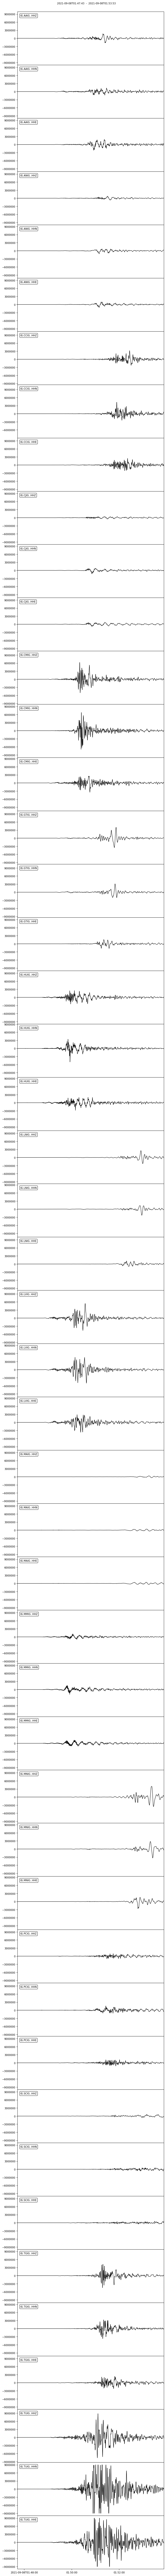

In [47]:
st.plot();

# Modelo de Velocidades para obtener más exactitud/precisión

### Probar con otros sismos (checar diario de investigación)

In [11]:
for i, row in df_catalog.iterrows():
    evid = row.date_time_id
    evdir = directorio_recortado + evid + '/'
    stations_meta = get_meta_data(evdir)
    #ev_st_df = link_ev_st(evdir)
    ev_st_df = pd.read_csv('ev_st_%s.csv'%(evid))
    
    # Directorio de funciones de Green
    green_dir = "%s/%s"%(evdir,model)
    if os.path.exists(green_dir):
        shutil.rmtree(green_dir)
    
    depth = row.depth
    
    #round(df_catalog.loc[df_catalog['date_time_id'] == evid]["depth"].values[0])]
    if depth >= 22:
        depths = list(range(int(depth)-20, int(depth)+25, 10))
    else:
        depths = list(range(2, 30, 4))
        
    npts = int(256) # numero de puntos
    t0 = int(0)
    ev_st_sub = ev_st_df.loc[ev_st_df['date_time_id'] == evid].sort_values('st', ascending=True).copy()
    print(ev_st_df)

    Path(green_dir).mkdir(parents=True,exist_ok=True)

    for depth in depths:
        dfile = ("{dist:.0f} {dt:.2f} {npts:d} {t0:d} {vred:.1f}\n")
        dfile_out = "%s/dfile"%evdir
        with open(dfile_out,"w") as f:
            # Distancia con cada estacion
            # Aqui necesitamos indicar una distancia por cada estacion-canal
            for i, distance in ev_st_sub['distance'].drop_duplicates().reset_index(drop=True).iteritems():
                f.write(dfile.format(dist=distance,dt=dt,npts=npts,t0=t0,vred=vred))

        # Generate the synthetics
        os.system("hprep96 -M %s.d -d %s -HS %.4f -HR 0 -EQEX"%(model,dfile_out,depth))
        !hspec96
        !hpulse96 -D -i > file96
        !f96tosac -B file96

        greens = ("ZDD","RDD","ZDS","RDS","TDS","ZSS","RSS","TSS","ZEX","REX")

        for i, sta in stations_meta['kstnm'].drop_duplicates().reset_index(drop=True).iteritems():      
            for j, grn in enumerate(greens):
                sacin = "B%03d%02d%s.sac"%(i+1,j+1,grn)
                sacout = "%s/%s.%.4f"%(green_dir,sta,depth)
                tmp = read(sacin,format="SAC")
                tmp.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
                tmp.write("%s.%s"%(sacout,grn),format="SAC") # overwrite

    !\rm B*.sac

     Unnamed: 0  Unnamed: 0.1                    starttime  \
0             0             0  2021-09-08T01:47:43.000000Z   
1             1             1  2021-09-08T01:47:43.000000Z   
2             2             2  2021-09-08T01:47:43.000000Z   
3             3             3  2021-09-08T01:47:43.000000Z   
4             4             4  2021-09-08T01:47:43.000000Z   
..          ...           ...                          ...   
979        1060          1060  2019-09-30T23:15:22.000000Z   
980        1061          1061  2019-09-30T23:15:22.000000Z   
981        1062          1062  2019-09-30T23:15:22.000000Z   
982        1063          1063  2019-09-30T23:15:22.000000Z   
983        1064          1064  2019-09-30T23:15:22.000000Z   

                         endtime  sampling_rate    st   ch  \
0    2021-09-08T01:53:53.000000Z          100.0  MCIG  HHZ   
1    2021-09-08T01:53:53.000000Z          100.0  TJIG  HHE   
2    2021-09-08T01:53:53.000000Z          100.0  SSIG  HHN   
3    20

La librería mttime toma las direcciones de los sismogramas observados y sintéticos como relativas a la ubicación de mtinv.inv (el archivo de configuración para la inversión), así que solo es necesario colocar Filt y gil7.

In [12]:
for i, row in df_catalog.iterrows():
    evid = row.date_time_id
    evdir = directorio_recortado + evid + '/'
    stations_meta = get_meta_data(evdir)
    
    ev_st_df = pd.read_csv('ev_st_%s.csv'%(evid))
    
    depth = row.depth
    
    if depth >= 22:
        depths = list(range(int(depth)-20, int(depth)+25, 10))
    else:
        depths = list(range(2, 30, 4))
    
    filtdir = "%s/%s"%(evdir,obs)
    green_dir = "%s/%s"%(evdir,model)
    
    headers = dict(datetime=row.date_time,
                   longitude=row.lon,
                   latitude=row.lat,
                   depth=",".join([ "%.4f"%d for d in depths]),
                   path_to_data=obs,
                   path_to_green=model,
                   green="herrmann",
                   components="ZRT", # ZRT y ZNE unicas opciones
                   degree=5,
                   weight="distance",
                   plot=0,
                   correlate=0,
                  )
    
    row_st = ev_st_df.loc[ev_st_df['date_time_id'] == evid].sort_values('st', ascending=True)

    pd.options.display.float_format = "{:,.2f}".format
    frame = {"station": row_st["st"]}
    df_out = pd.DataFrame(frame)

    
    df_out["distance"] = row_st["distance"]
    df_out["azimuth"] = row_st["azimuth"]
    df_out["ts"] = int(30)
    df_out["npts"] = int(150)
    df_out["dt"] = dt
    df_out["used"] = 1
    
    ordered_stations = row_st.merge(stations_meta, left_on=['st', 'ch'], right_on=['kstnm', 'kcmpnm'])[['st', 'stlo', 'stla']]
    
    df_out[["longitude","latitude"]] = ordered_stations[["stlo","stla"]].values
    
    df_out.drop_duplicates(inplace=True)
    
    with open(evdir+"/mtinv.in","w") as f:
        for key, value in headers.items():
            f.write("{0:<15}{1}\n".format(key,value))
        f.write(df_out.to_string(index=False))

In [12]:
#!cat mtinv.in